In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

import utils.utils as utils

import os
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


In [4]:
class LossNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
        

        self.feature_maps = dict()
        self.feature_maps['relu1_2'] = nn.Sequential()
        self.feature_maps['relu2_2'] = nn.Sequential()
        self.feature_maps['relu3_4'] = nn.Sequential()
        self.feature_maps['relu4_4'] = nn.Sequential()
        self.feature_maps['relu5_4'] = nn.Sequential()

        names = ['relu1_2', 'relu2_2', 'relu3_4', 'relu4_4', 'relu5_4']
        
        i = 1
        j = 1

        for layer in cnn.children():

            if isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
                i += 1
                j = 1
            elif isinstance(layer, nn.Conv2d):
                name = 'conv{}_{}'.format(i,j)
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}_{}'.format(i,j)
                j += 1

            if i == 6:
                break
            
            self.feature_maps[names[i-1]].add_module(name,layer)
        
        for param in self.parameters():
                param.requires_grad = False


    def forward(self,x):
            
        x = self.feature_maps['relu1_2'](x)
        feature_map1 = x
        x = self.feature_maps['relu2_2'](x)
        feature_map2 = x
        x = self.feature_maps['relu3_4'](x)
        feature_map3 = x
        x = self.feature_maps['relu4_4'](x)
        feature_map4 = x
        x = self.feature_maps['relu5_4'](x)
        feature_map5 = x

        return feature_map1, feature_map2, feature_map3, feature_map4, feature_map5

In [15]:
def NST(content_path, style_path, input_path, content_width, num_steps=100, content_weight=1, style_weight=1e6):

    loss_net = LossNetwork().to(device)

    content_image = utils.prepare_img(content_path, content_width, device)
    style_image = utils.prepare_img(style_path, None, device)

    content_features = loss_net(content_image)
    style_features = loss_net(style_image)

    style_grams = []
    for feature_map in style_features:
        style_grams.append(gram_matrix(feature_map))

    if input_path == None:
        input_image = content_image.clone()

    input_image.requires_grad_(True)

    loss_net.eval()
    loss_net.requires_grad_(False)

    optimizer = optim.LBFGS([input_image])

    run = [0]
    while run[0] <= num_steps:

        def closure():   
            


            # clear gradients 
            optimizer.zero_grad()  

            # Feed input image to loss net (VGG19)
            input_features = loss_net(input_image)

            # Calculate content loss
            content_target = content_features[3]
            input_content = input_features[3]
            content_loss = F.mse_loss(content_target, input_content, reduction='mean')

            # Calculate style loss
            style_loss = 0.0

            input_grams = []
            for feature_map in input_features:
                input_grams.append(gram_matrix(feature_map))
        
            for k in range(5):
                style_loss += F.mse_loss(style_grams[k], input_grams[k], reduction='mean')
            
            # Combine losses and do a backprop
            total_loss = content_weight*content_loss + style_weight*style_loss 
            total_loss.backward(retain_graph=True)

            run[0] += 1
            print('step {}'.format((run)))
            print('loss: {}'.format(total_loss))

            return total_loss
        
        optimizer.step(closure)

    return input_image
    



In [16]:
content_path = "./images/dancing.jpg"
style_path = "./images/vg_starry_night.jpg"
input_path = None 
content_width = 512

input_image = NST(content_path, style_path, input_path, content_width)


step [1]
loss: 4421.13623046875
step [2]
loss: 4421.1279296875
step [3]
loss: 4955.0361328125
step [4]
loss: 3096.393310546875
step [5]
loss: 1346.289794921875
step [6]
loss: 89824.9921875
step [7]
loss: 1049.5679931640625
step [8]
loss: 832.842529296875
step [9]
loss: 1899.279296875
step [10]
loss: 362.3553771972656
step [11]
loss: 264.5471496582031
step [12]
loss: 233.23074340820312
step [13]
loss: 186.16787719726562
step [14]
loss: 164.69239807128906
step [15]
loss: 116.42620086669922
step [16]
loss: 79.98223876953125
step [17]
loss: 75.35061645507812
step [18]
loss: 61.81904983520508
step [19]
loss: 55.605064392089844
step [20]
loss: 51.023399353027344
step [21]
loss: 46.301918029785156
step [22]
loss: 37.505523681640625
step [23]
loss: 34.7979850769043
step [24]
loss: 31.93435287475586
step [25]
loss: 28.35246467590332
step [26]
loss: 26.412553787231445
step [27]
loss: 24.422903060913086
step [28]
loss: 22.51181411743164
step [29]
loss: 20.983274459838867
step [30]
loss: 18.710586

In [17]:
input_image_detached = input_image.detach().numpy()[0]


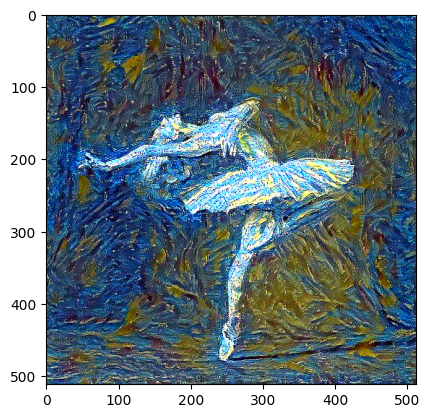

In [18]:
utils.display_image(input_image_detached)